In [991]:
%matplotlib inline
from preamble import *

In [992]:
import torch
import torch.nn as nn

# Conventions for this notebook

## Jargon
- Unit = activation = neuron
- Model = neural network
- Feature = dimension of input vector
- Hypothesis = output of the model


## Indices
- $j$ = layer label
- $i$ = unit label in a particular layer
- $m$ = number of features (length of input vector)

## Scalars
- $L$ = total number of layers
- $u^j$ = number of units in layer $j$
- $a_i^j$ is the activation unit $i$ in layer $j$

## Vectors and matrices
- $x$: input vector of dimension $(m \times 1)$
- $a^j$: activation vector of layer $j$ of dimension $(u^j \times 1)$
- $\theta^j$: weight matrix from layer $j$ to $j+1$, of dimension $[u^{j+1} \times (u^j + 1)]$, 
<span style='color:Blue'> where the $+1$ accounts for the bias unit </span>



$$
x =
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_m
\end{bmatrix} \ \ ; \ \
\theta^j =
\begin{bmatrix}
\theta_{10} & \dots & \theta_{1(u^j + 1)}\\
\theta_{20} & \ddots\\
\vdots \\
\theta_{(u^{j+1}) 0} & & \theta_{(u^{j+1})(u^j + 1)}\\
\end{bmatrix} 
$$



# 0. Introduction
In this notebook we will train a neural network to fit an arbitrary function.

## 0.1. Universal Approximation Theorem
- When the activation function is non-linear, then a two-layer neural network can be proven to be a **universal function approximator**.
- <span style='color:red'> This is where the power of neural networks comes from! </span>

## 0.2. Load the function to fit
In this case it is a small part of a coherent synchrotron radiation signal at KARA. Notice that this data is considered to have only one feature.

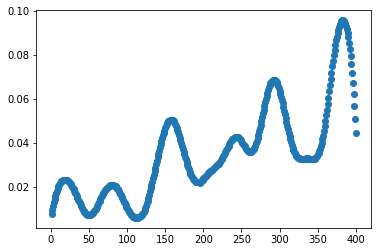

In [993]:
hf_data = h5py.File('data/data_nb1.h5', 'r')
y = np.asarray(hf_data.get('pulse'))
x = np.arange(1, len(y) + 1)
hf_data.close()
plt.scatter(x, y)

Before starting, let's convert our numpy arrays to torch tensors.
The model will take only `float` types.

In [994]:
# n_input, n_hidden, n_out, batch_size, learning_rate = len(y), int(len(y)/5), len(y), 100, 0.01
n_input, n_hidden, n_out, batch_size, learning_rate = 10, 15, 10, 100, 0.015

In [995]:
print(x.shape)

(400,)


In [996]:
x_reshape = x.reshape((int(len(x) / n_input), n_input))

In [997]:
print(x_reshape.shape)

(40, 10)


In [998]:
print(x.dtype, y.dtype)

int64 float32


In [999]:
x_reshape = x_reshape.astype(np.float32)

In [1000]:
print(x.dtype, y.dtype)

int64 float32


In [1001]:
yt = torch.from_numpy(y)
xt = torch.from_numpy(x_reshape)

<span style='font-family:"Helvetica"; background:yellow; font-size:1.4em' >
 How much do you think each hyperparameter will affect the quality of the model? 
</span>

# 2. Build your model

- In PyTorch [`Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) stands for *sequential container*, where modules can be added sequentially and are connected in a cascading way. The output for each module is forwarded sequentially to the next.
- Now we will build a simple model with one hidden layer with `Sequential`
- Remember that every layer in a neural network is followed by an **activation layer** that performs some additional operations on the neurons.

## 2.1 Activation functions

## 2.2. Model architecture

In [1002]:
model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.Tanh(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())
print(model)

Sequential(
  (0): Linear(in_features=10, out_features=15, bias=True)
  (1): Tanh()
  (2): Linear(in_features=15, out_features=10, bias=True)
  (3): Sigmoid()
)


You can uncomment and execute the next line to explore the methods of the `model` object you created

In [1003]:
# dir(model)

## 2.1 - Understanding the PyTorch model
Try the `parameters` method (needs to be instantiated).

In [1004]:
model.parameters()

<generator object Module.parameters at 0x7fda51ffc430>

The `parameters` method gives back a *generator*, which means it needs to be iterated over to give back an output:

In [1005]:
for element in model.parameters():
    print(element.shape)

torch.Size([15, 10])
torch.Size([15])
torch.Size([10, 15])
torch.Size([10])


<span style='font-family:"Helvetica"; background:yellow; font-size:1.4em' >
     Without taking into account any bias unit: can you identify the elements of the model by their dimensions?
</span>

- The first element corresponds to the weight matrix $\theta^1$ from layer 1 to layer 2, of dimensions $u^{j+1} \times u^j = u^2 \times u^1 = 15 \times 10$
- The second element corresponds to the values of the activation units in layer 2
- The third element corresponds to the weight matrix $\theta^2$ from layer 2 to layer 3, of dimensions $u^{j+1} \times u^j = u^3 \times u^3 = 1 \times 15$
- The fourth element is the output of the model

Let's have a look at what the contents of those tensors:

In [1006]:
# for element in model.parameters():
#     print(element)

<span style='font-family:"Helvetica"; background:yellow; font-size:1.4em' >
     What are these values?
</span>

They have been randomly initialized

- The first element corresponds to the weight matrix $\theta^1$ from layer 1 to layer 2, of dimensions $u^{j+1} \times u^j = u^{2} \times (u^1) = 15 \times 10$
- The second element corresponds to the values of the activation units in layer 2
- The third element corresponds to the weight matrix $\theta^2$ from layer 2 to layer 3, of dimensions $u^{j+1} \times u^j = u^{3} \times (u^2) = 1 \times 15$
- The fourth element is the output of the model

# 3 - Define the loss function
- Reminder: the **loss function** measures how distant the predictions made by the model are from the actual values
- `torch.nn` provides many different types of [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions). One of the most popular ones in the [Mean Squared Error (MSE)](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) since it can be applied to a wide variety of cases.
- In general cost functions are chosen depending on desirable properties, such as convexity.

In [1007]:
loss_function = nn.MSELoss()

# 4 - Define the optimizer
[`torch.optim`](https://pytorch.org/docs/stable/optim.html) provides implementations of various optimization algorithms. The optimizer object will hold the current state and will update the parameters of the model based on computer gradients. It takes as an input an iterable containing the model parameters, that we explored before.

In [1008]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 5 - Train the model on a loop
The model learns iteratively in a loop of a given number of epochs. Each loop consists of:
- A **forward propagation**: compute $y$ given the input $x$ and current weights and calculate the loss
- A **backward propagation**: compute the gradient of the loss function (error of the loss at each unit)
- Gradient descent: update model weights

In [1009]:
print(xt.dtype, yt.dtype)

torch.float32 torch.float32


In [1010]:
# for i in xt:
#     pred_y = model(i.unsqueeze(dim=0))

In [1011]:
# losses = []
# for epoch in range(5000):
#     pred_y = model(xt)
#     loss = loss_function(pred_y, yt)
#     losses.append(loss.item())

#     # Zero gradients from previous steps
#     model.zero_grad()
    
#     # Perform backpropagation
#     loss.backward()
    
#     # Update model parameters
#     optimizer.step()

In [1012]:
# for xx, yy in zip(xt, yt):
#     print(xx)
#     print(xx.unsqueeze(dim=0))

In [1013]:
losses = []
for epoch in range(300):
    for xx, yy in zip(xt, yt):
        pred_y = model(xx.unsqueeze(dim=0))
        loss = loss_function(pred_y, yy.unsqueeze(dim=0))
        losses.append(loss.item())

        # Zero gradients from previous steps
        model.zero_grad()

        # Perform backpropagation
        loss.backward()

        # Update model parameters
        optimizer.step()

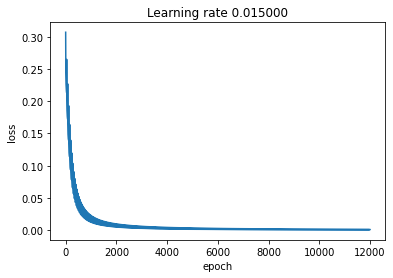

In [1014]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [1015]:
x_pred = np.random.uniform(0, 400, 100)
xtt = x_pred.astype(np.float32)
print(xtt.dtype)
xtt = xtt.reshape((int(len(xtt) / n_input), n_input))
x_pred_t = torch.from_numpy(xtt)

float32


In [1016]:
y_pred_t = torch.empty((100,1))
y_pred_t = []

for i in x_pred_t:
    j = model(i.unsqueeze(dim=0))
#     print(j)
#     print(j.detach().numpy())
#     torch.add(y_pred_t, j)
    y_pred_t.append(j.detach().numpy())

In [1017]:
y_pred_t = np.asarray(y_pred_t)

In [1018]:
y_pred_t = y_pred_t.flatten()

In [1019]:
print(y_pred_t.shape, x_pred.shape)

(100,) (100,)


In [1020]:
# print(y_pred_t)

In [1021]:
# print(y_pred_t.numpy())

In [1022]:
# plt.plot(x, y)
# plt.scatter(x_pred, y_pred_t)
# plt.ylim([0, 0.1])